In [94]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [95]:
#Load the data
print("-------------------------------- Load IS --------------------------------")
experiment_ext = "allfalse"
name_experiment_is = "is_phi_phi_" + experiment_ext
path_start = "./outputs/" + name_experiment_is + "/"
lst_data_is = []
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_is.append(json.load(file))
                    print("Loaded: " + path)
print("-------------------------------- Load MH --------------------------------")
name_experiment_mh = "metropolis_phi_phi_" + experiment_ext
path_start = "./outputs/" + name_experiment_mh + "/"
lst_data_mh = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_mh.append(json.load(file))
                    print("Loaded: " + path)


-------------------------------- Load IS --------------------------------
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-40-30_442/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-36-53_439/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-56-34_443/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-36-45_438/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-39-20_441/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-56-34_444/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-56-34_445/all.json
Loaded: ./outputs/is_phi_phi_allfalse/2024-08-21/00-37-11_440/all.json
-------------------------------- Load MH --------------------------------
Loaded: ./outputs/metropolis_phi_phi_allfalse/2024-08-21/09-02-40_438/all.json


In [96]:
# For fair comparison it is better to compare with the same true rule
true_rule = lst_data_mh[0]["true_rule"]
for data in lst_data_mh + lst_data_is:
    assert data["true_rule"] == true_rule
    print(len(data["rules"]))

1608
188
191
188
188
191
188
191
189


In [97]:
# Reconstruct all rules IS
all_rules_is = []
all_likelihoods_is = []
all_weights_is = []
for data in lst_data_is:
    all_rules_is.append(np.repeat(data["rules"], data["metrics"]["counts"]))
    all_likelihoods_is.append(np.repeat(data["likelihoods"], data["metrics"]["counts"]))
    all_weights_is.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
all_rules_is = np.stack(all_rules_is)
all_likelihoods_is = np.stack(all_likelihoods_is)
all_weights_is = np.stack(all_weights_is)

In [98]:
# Reconstruct all rules MH
all_rules_mh = []
all_likelihoods_mh = []
all_weights_mh = []
all_prev_rules_ind_mh = []
for data in lst_data_mh:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules_mh.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods_mh.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights_mh.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind_mh.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules_mh = np.concatenate(all_rules_mh, axis=0)
all_likelihoods_mh = np.concatenate(all_likelihoods_mh, axis=0)
all_weights_mh = np.concatenate(all_weights_mh, axis=0)
all_prev_rules_ind_mh = np.concatenate(all_prev_rules_ind_mh, axis=0)

In [99]:
# Compare best rule for IS and MH
# Best rules of each method
best_taken = 50
best_rules_ind_mh = np.argsort(-all_likelihoods_mh.flatten())[:best_taken]
best_rules_ind_is = np.argsort(-all_likelihoods_is.flatten())[:best_taken]
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten()[best_rules_ind_mh], all_likelihoods_is.flatten()[best_rules_ind_is]])
all_rules = np.concatenate([all_rules_mh.flatten()[best_rules_ind_mh], all_rules_is.flatten()[best_rules_ind_is]])
indices = np.argsort(-all_likelihoods)
for incr, ind in enumerate(indices):
    if ind < best_taken:
        color_start = "\x1b[31m"
        color_end = "\x1b[0m"
    else:
        color_start = "\033[92m"
        color_end = "\033[0m"
    print(
        f"{color_start}-----rule-----:{incr}: {repr(all_rules[ind])}, likelihood: {all_likelihoods[ind]:2f}{color_end}"
    )

-----rule-----:0: 'The door remains closed regardless of the objects being held by the individual. The rule for the door being open or closed does not seem to be related to the objects or the colors and sizes of the objects in possession.', likelihood: -0.110075
-----rule-----:1: 'The door remains closed regardless of the object or its color and size. There is no specific rule for the door to open based on these objects.', likelihood: -0.126948
-----rule-----:2: 'The rule for the door is that it remains closed regardless of the object being held or its color and size. All the given combinations of objects have resulted in the door being closed.', likelihood: -0.137992
-----rule-----:3: "The rule for opening/closing the door can be summarized as: The door's status is unaffected by the color or size of the object held, with no given method to operate or open the door.", likelihood: -0.147050
-----rule-----:4: 'None of the key, card, or ball can unlock or open the door.', likelihood: -0.1

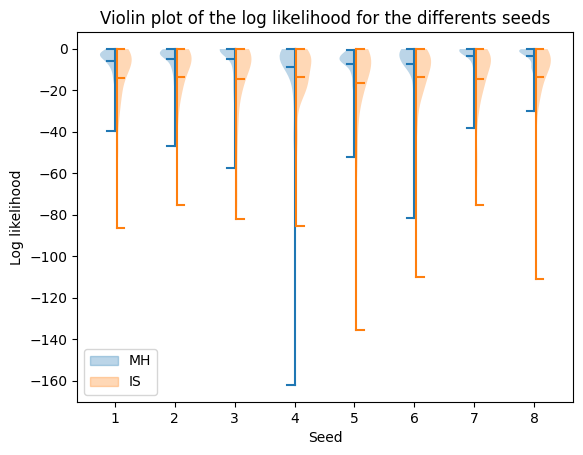

In [100]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

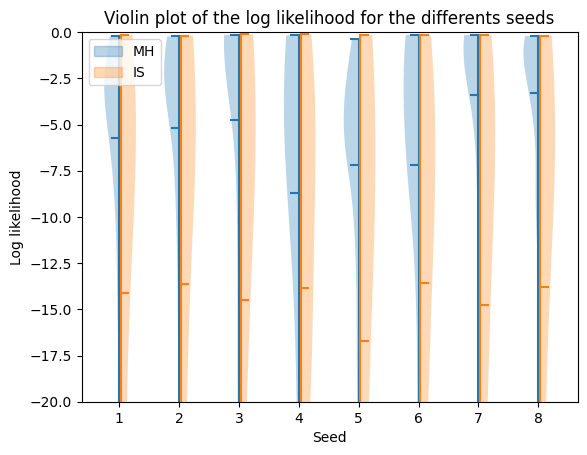

In [101]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
fig,ax = plt.subplots()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
ax.set_ylim(-20,0)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

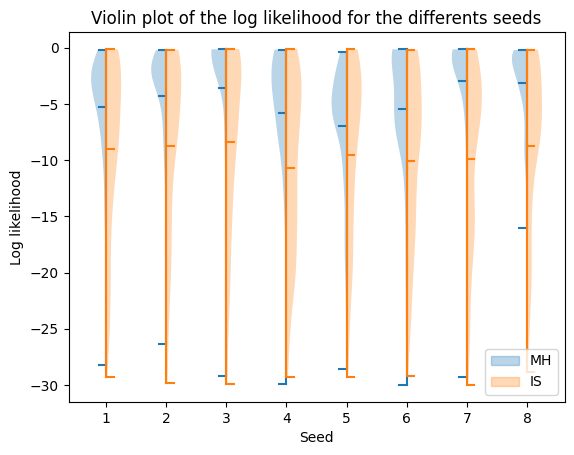

In [102]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms for high likelihoods
min_likelihood=-30
high_likelihoods_mh = [all_likelihoods_mh[row][all_likelihoods_mh[row] > min_likelihood] for row in range(len(all_likelihoods_mh))]
high_likelihoods_is = [all_likelihoods_is[row][all_likelihoods_is[row] > min_likelihood] for row in range(len(all_likelihoods_is))]
fig,ax = plt.subplots()
color_mh = plt.violinplot(high_likelihoods_mh, showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(high_likelihoods_is, showmeans=True, side="high")["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

# Embeddings

In [109]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules_mh.flatten(), all_rules_is.flatten()], axis=0))

In [110]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

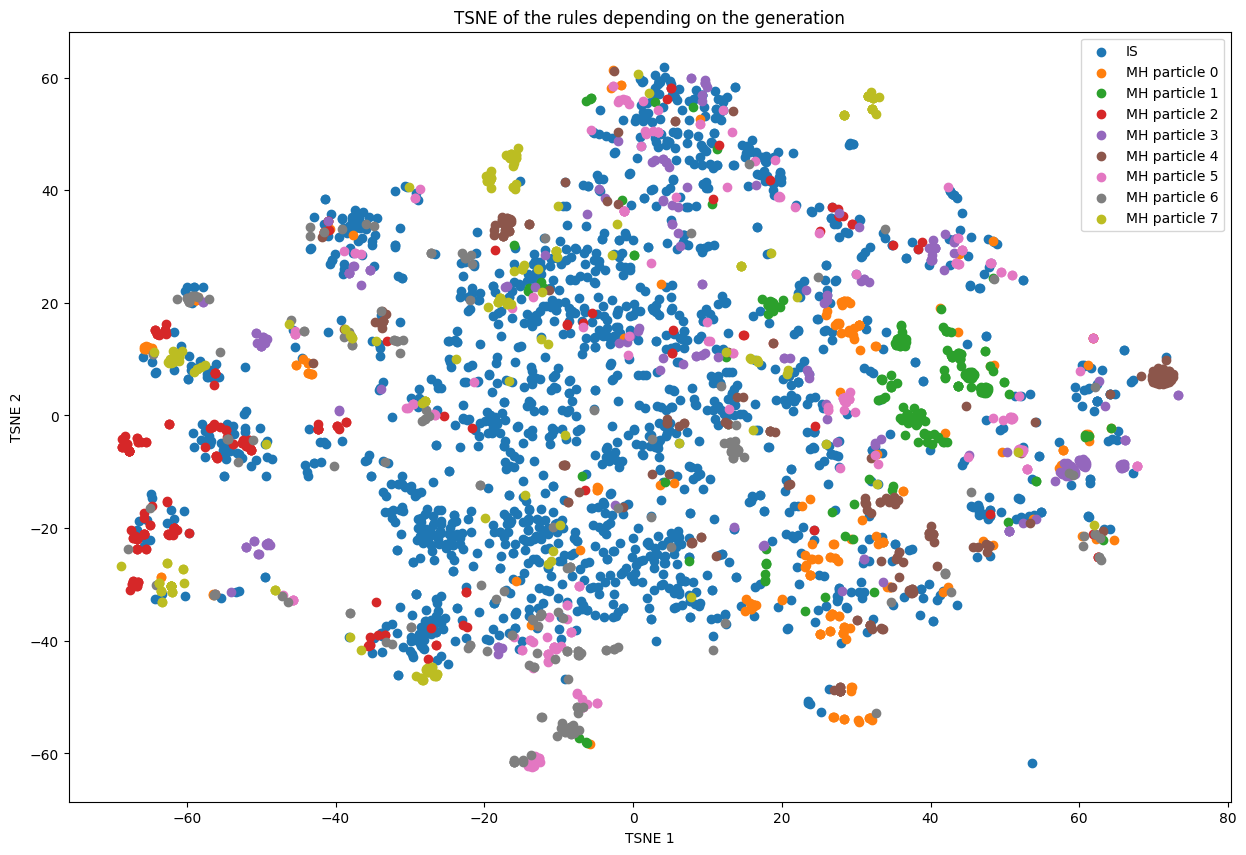

In [118]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

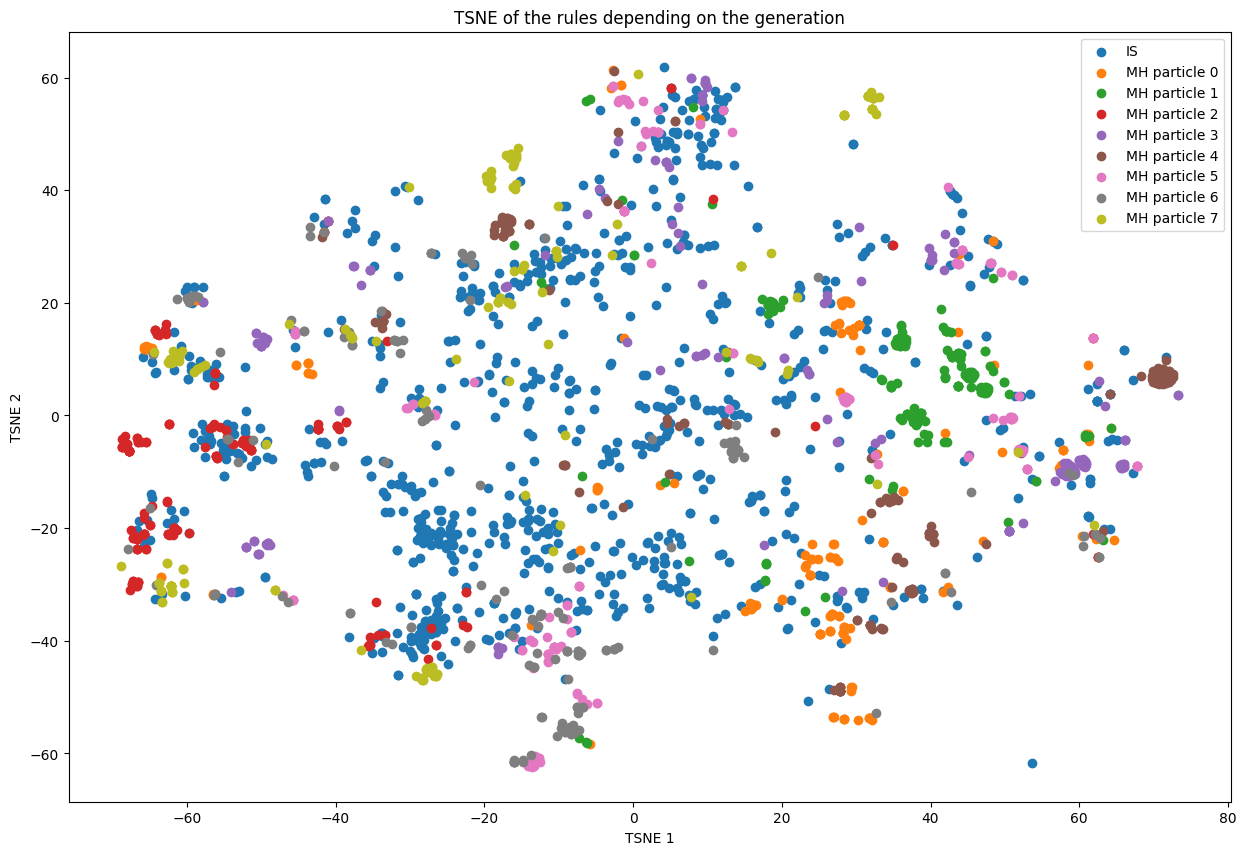

In [129]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -10
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_mh.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    mask_mh = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_mh.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_mh.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_mh,0], proj_embeddings[mask_likelihood&mask_mh,1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()